I obtained data from Kaggle (originally from the website 'Ease my Trip'), which contains individual flight options collected from February 11th to March 31st, 2022. This dataset contains information for flight travel between India's top 6 metro cities. There are 300,261 datapoints and 11 features in the dataset.

link: https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction?select=economy.csv


# Pre-Processing & Preliminary Analysis

<Axes: >

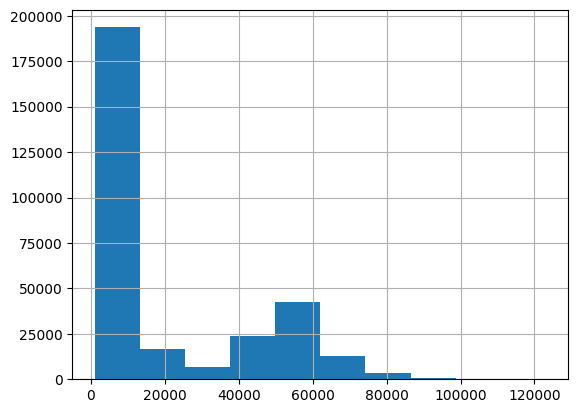

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error, r2_score, explained_variance_score
import math

# Load data
flight = pd.read_csv('flights.csv')

# Remove serial number column (1st column)
flight = flight.iloc[:, 1:]

# Target variable distribution
flight.price.hist()

Based on our target variable distribution, we notice that the majority of ticket prices are below 200 dollars.
There is a slight increase in ticket prices at and around 600 dollars.

Missing values:
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64


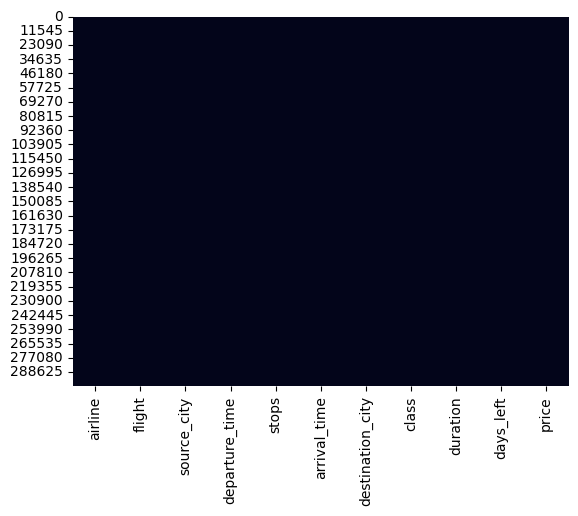

In [ ]:
# Check for missing values
sns.heatmap(flight.isnull(),cbar=False)

missing = flight.isnull().sum()
print("Missing values:")
print(missing)

In [ ]:
flight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   flight            300153 non-null  object 
 2   source_city       300153 non-null  object 
 3   departure_time    300153 non-null  object 
 4   stops             300153 non-null  object 
 5   arrival_time      300153 non-null  object 
 6   destination_city  300153 non-null  object 
 7   class             300153 non-null  object 
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 25.2+ MB


There are no missing values for any of the variables in this dataset.

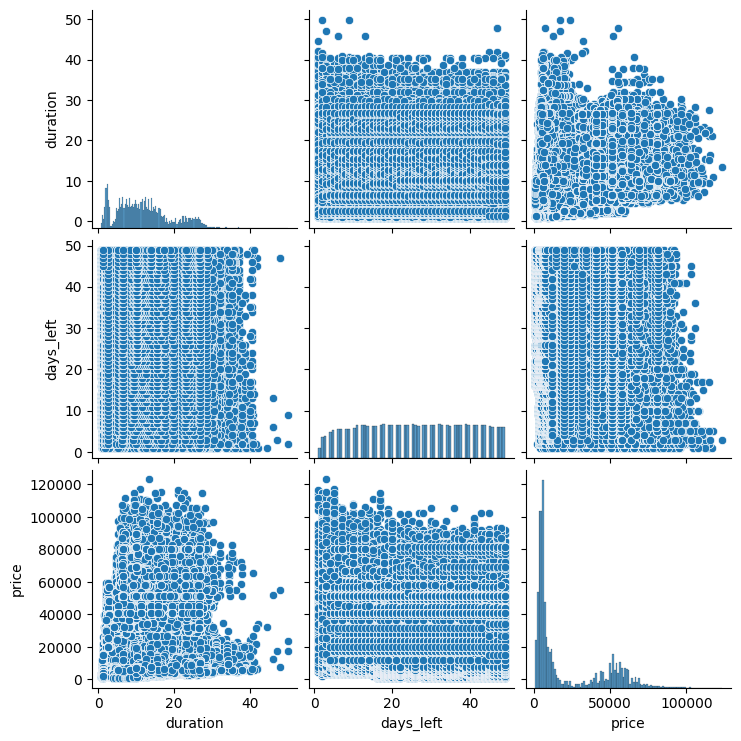

In [ ]:
# Explore info value & feature distribution with pairplot
sns.pairplot(flight)
plt.show()

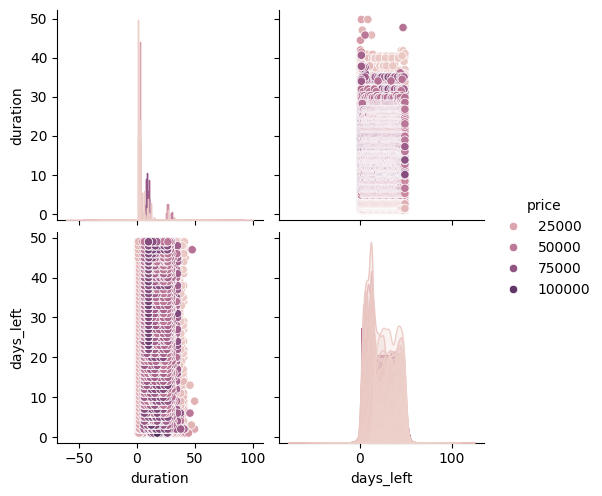

In [ ]:
# Additional Pairplot with Hue for 'Price'
sns.pairplot(flight, hue='price')
plt.show()

In [ ]:
# Variables to be classified as categorical
flight['stops'] = flight['stops'].astype('category')
flight['class'] = flight['class'].astype('category')
flight['source_city'] = flight['source_city'].astype('category')
flight['destination_city'] = flight['destination_city'].astype('category')
flight['departure_time'] = flight['departure_time'].astype('category')
flight['arrival_time'] = flight['arrival_time'].astype('category')
flight['airline'] = flight['airline'].astype('category')


# Encoding stops & class
flight["stops"] = flight["stops"].replace({'zero': 0, 'one': 1, 'two_or_more': 2}).astype(int)
flight["class"] = flight["class"].replace({'Economy': 0, 'Business': 1}).astype(int)

# copy data for encoded versions of variables
flight_encode = flight.copy()

# encode source_city, destination_city
flight_encode['source_city'] = flight_encode['source_city'].replace({
    'Bangalore': 0,
    'Chennai': 1,
    'Delhi': 2,
    'Hyderabad': 3,
    'Kolkata': 4,
    'Mumbai': 5
})
flight_encode['destination_city'] = flight_encode['destination_city'].replace({
    'Bangalore': 0,
    'Chennai': 1,
    'Delhi': 2,
    'Hyderabad': 3,
    'Kolkata': 4,
    'Mumbai': 5
})

# encode departure_time, arrival_time
flight_encode['departure_time'] = flight_encode['departure_time'].replace(
{   'Early_Morning': 0,
    'Morning': 1,
    'Afternoon': 2,
    'Evening': 3,
    'Night': 4,
    'Late_Night': 5
})
flight_encode['arrival_time'] = flight_encode['arrival_time'].replace(
{   'Early_Morning': 0,
    'Morning': 1,
    'Afternoon': 2,
    'Evening': 3,
    'Night': 4,
    'Late_Night': 5
})

# encode airline
flight_encode['airline'] = flight_encode['airline'].replace(
{   'Air_India': 0,
    'AirAsia': 1,
    'GO_FIRST': 2,
    'Indigo': 3,
    'SpiceJet': 4,
    'Vistara': 5
})


# adding decimal to "price" variable
flight_encode['price'] = flight_encode['price'].astype(str)
flight_encode['price'] = flight_encode['price'].str[:-2] + '.' + flight_encode['price'].str[-2:]
flight_encode['price'] = flight_encode['price'].astype(float)

# remove 'flight' variable
flight_encode.drop('flight', axis=1, inplace=True)

# verify changes to data
flight_encode.head()


,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,4,2,3,0,4,5,0,2.17,1,59.53
1,4,2,0,0,1,5,0,2.33,1,59.53
2,1,2,0,0,0,5,0,2.17,1,59.56
3,5,2,1,0,2,5,0,2.25,1,59.55
4,5,2,1,0,1,5,0,2.33,1,59.55


In [ ]:
# Descriptive Stats
flight_encode.describe()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
count,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000
mean,2.889003,2.577592,1.867814,0.924312,2.699087,2.588303,0.311464,12.221021,26.004751,208.896605
std,2.106868,1.751762,1.416183,0.398106,1.351441,1.744543,0.463093,7.191997,13.561004,226.977674
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.830000,1.000000,11.050000
25%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,6.830000,15.000000,47.830000
50%,3.000000,2.000000,2.000000,1.000000,3.000000,3.000000,0.000000,11.250000,26.000000,74.250000
75%,5.000000,4.000000,3.000000,1.000000,4.000000,4.000000,1.000000,16.170000,38.000000,425.210000
max,5.000000,5.000000,5.000000,2.000000,5.000000,5.000000,1.000000,49.830000,49.000000,1230.710000


# Visualizations

<ipython-input-7-59969e64d17e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='airline', y='price', data=flight, palette='Blues')


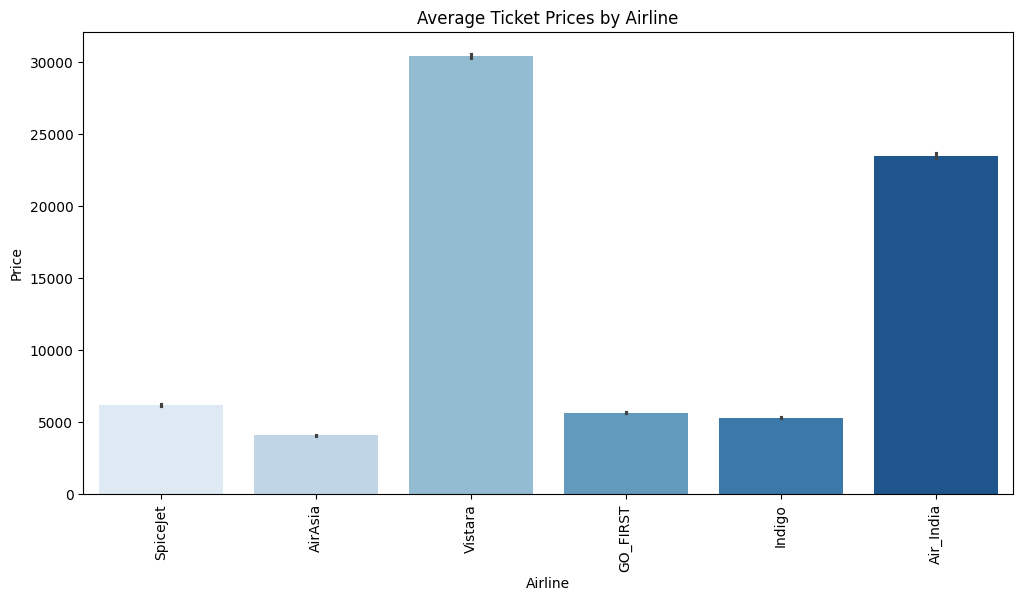

In [ ]:
# Barplot - Avg. Ticket Prices / Airline
plt.figure(figsize=(12, 6))
sns.barplot(x='airline', y='price', data=flight, palette='Blues')
plt.title('Average Ticket Prices by Airline')
plt.xlabel('Airline')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.show()

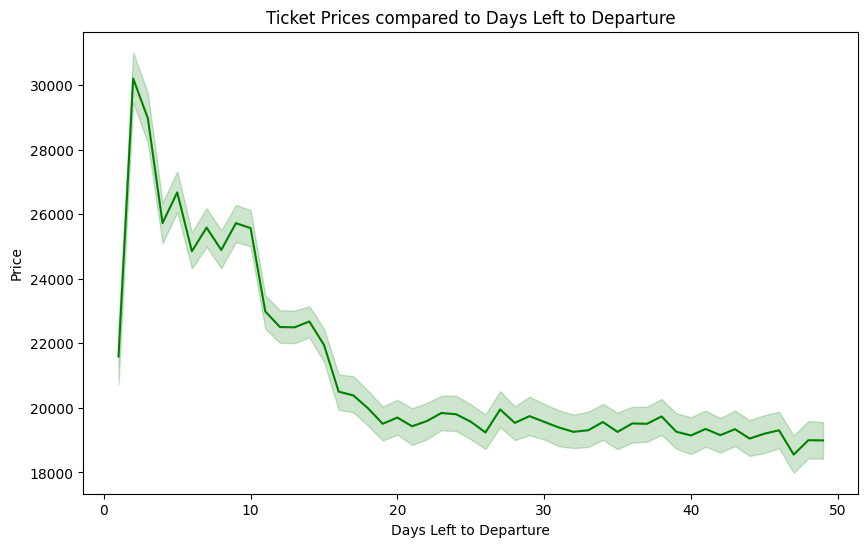

In [ ]:
# Line Plot - Ticket Prices / Days to Departure
plt.figure(figsize=(10, 6))
sns.lineplot(x='days_left', y='price', color='green', data=flight)
plt.title('Ticket Prices compared to Days Left to Departure')
plt.xlabel('Days Left to Departure')
plt.ylabel('Price')
plt.show()

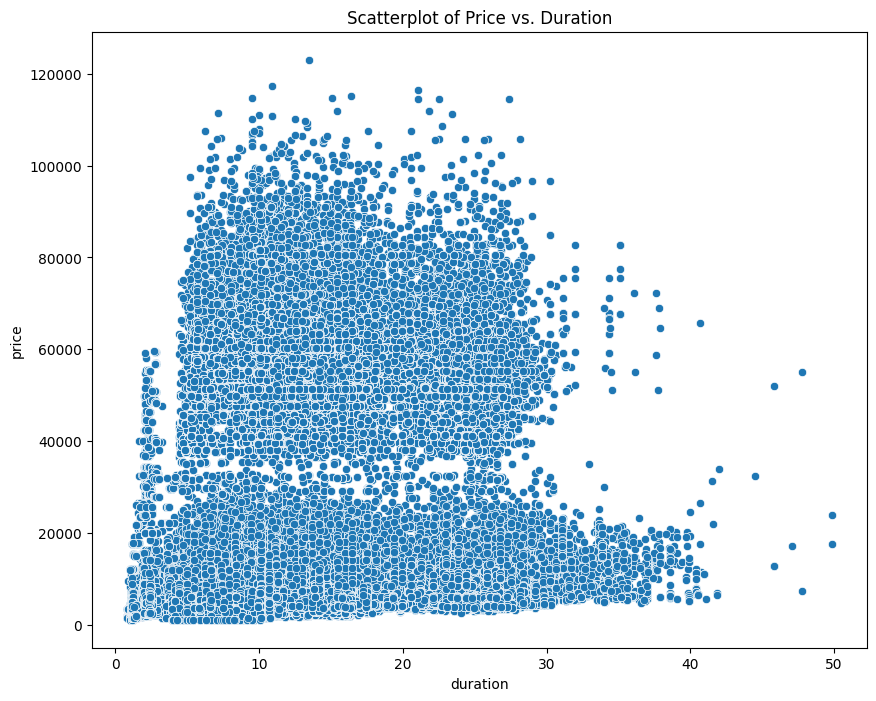

In [ ]:
# Scatterplot - Price / Duration
plt.figure(figsize=(10, 8))
sns.scatterplot(x='duration', y='price', data=flight)
plt.title('Scatterplot of Price vs. Duration')
plt.show()

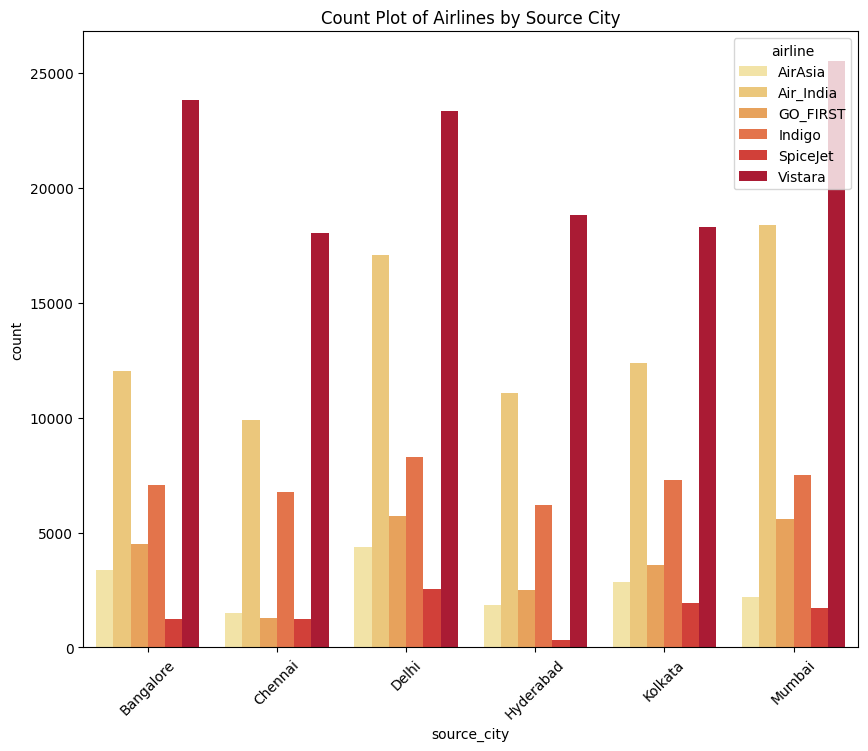

In [ ]:
# Countplot - Airlines / Source City
plt.figure(figsize=(10, 8))
sns.countplot(x='source_city', hue='airline', data=flight, palette='YlOrRd')
plt.title('Count Plot of Airlines by Source City')
plt.xticks(rotation=45)
plt.show()

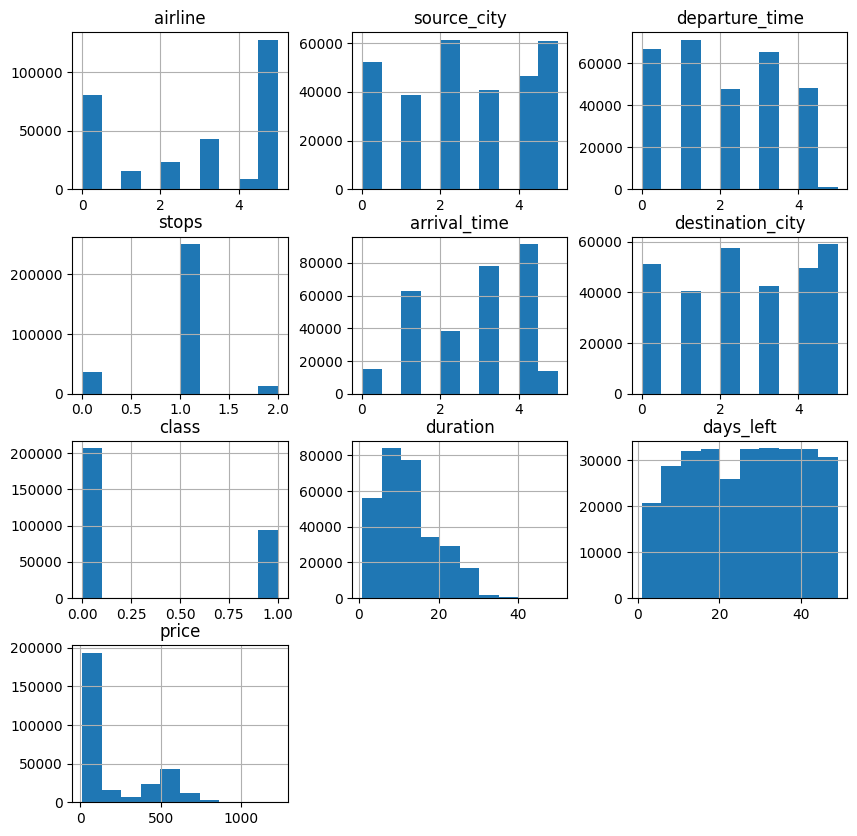

In [ ]:
# Data distribution with histograms
flight_encode.hist(figsize=(10,10))
plt.show()

The distributions above allow us to see each variables distribution following encoding.

**Airline:** Most flights are operated by Air India (0), followed by Indigo (3). AirAsia (1), GO_FIRST (2), SpiceJet (4), and Vistara (5) have fewer flights.

**Stops:** Most flights have one stop, followed by non-stop flights. Very few flights have two or more stops.

**Class:** Mostly economy class flights, with fewer business class.

**Source City:** Delhi (2) and Mumbai (5) are the most common source cities.

**Arrival Time:** Flights arriving in the evening/night are more common than other arrival times.

**Destination City:** Destination cities labeled as Delhi (2) and Mumbai (5) are most common, similar to source city.

**Duration:** There is a broad distribution in flight duration; shorter durations are more common.

**Days Left:** Flights departing within a short period are booked more frequently than flights scheduled for later dates.

**Price:** Most tickets fall into a lower price range, with a slight increase centered around 500 dollars.

# **Preliminary Models**

# **kNN Regression**

In [ ]:
# Train / Test sets
X = flight_encode.drop(['price'], axis=1)
y = flight_encode['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

# scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# find optimized k
knn = KNeighborsRegressor()
param_grid = {'n_neighbors': [3,5,7,9,11]}

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_k = grid_search.best_params_['n_neighbors']

print(best_k)


5


In [ ]:
# kNN
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)
knn_r2 = r2_score(y_test, y_pred_knn)

print("kNN:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_knn)}")
print(f"MSE: {mean_squared_error(y_test, y_pred_knn)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_knn))}")
print(f"R-squared: {knn_r2}")

kNN:
MAE: 18.21606845390134
MSE: 1386.8443095404573
RMSE: 37.24035861186701
R-squared: 0.9730535345726257


For our kNN regression model, we observed the mean absolute error, mean squared error, and root mean squared error with a k value of 5.
The MAE output indicates that our predictions differ from actual flight prices by approximately 18.22 dollars. The RMSE value shows that, on average, our predicted prices deviate from actual prices by 37.24 dollars. However, the MSE value indicates that there is a large number of overall errors in the predictions. The R2 value for this model indicates that 97% of variance in flight prices can be explained by the model, and the model is well-fitted.

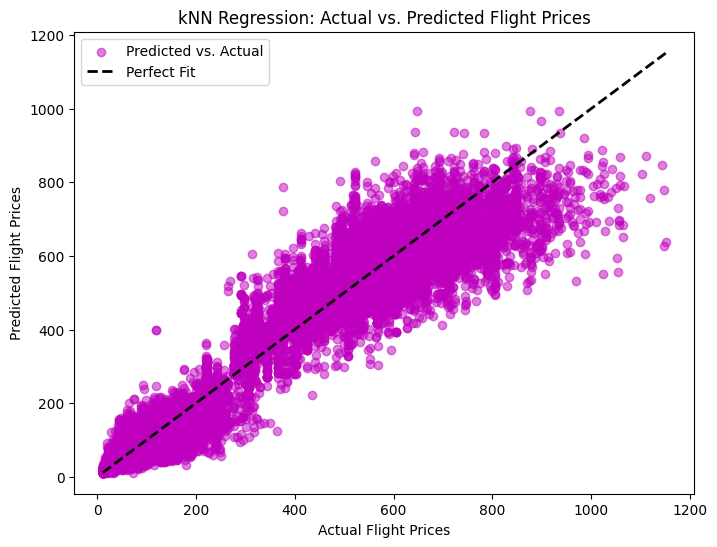

In [ ]:
# Scatterplot - actual vs. predicted flight prices
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_knn, color='m', alpha=0.5, label='Predicted vs. Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2, label='Perfect Fit')
plt.xlabel('Actual Flight Prices')
plt.ylabel('Predicted Flight Prices')
plt.title('kNN Regression: Actual vs. Predicted Flight Prices')
plt.legend()
plt.show()

# **Linear Regression**

In [ ]:
# Get summary statistics
X.describe()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left
count,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000
mean,2.889003,2.577592,1.867814,0.924312,2.699087,2.588303,0.311464,12.221021,26.004751
std,2.106868,1.751762,1.416183,0.398106,1.351441,1.744543,0.463093,7.191997,13.561004
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.830000,1.000000
25%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,6.830000,15.000000
50%,3.000000,2.000000,2.000000,1.000000,3.000000,3.000000,0.000000,11.250000,26.000000
75%,5.000000,4.000000,3.000000,1.000000,4.000000,4.000000,1.000000,16.170000,38.000000
max,5.000000,5.000000,5.000000,2.000000,5.000000,5.000000,1.000000,49.830000,49.000000


In [ ]:
#Linear Regression
LR = LinearRegression()
LR.fit(X_train_scaled, y_train)
y_pred_LR = LR.predict(X_test_scaled)
r2_LR = r2_score(y_test, y_pred_LR)

In [ ]:
# Functional Form
Intercept =LR.intercept_
Coeffiecients= LR.coef_

print(Intercept)
print(Coeffiecients)

208.95951581813077
[ 17.71876572   2.25007683  -0.95404138  23.15927894   3.97865851
   2.99177878 209.77515675   7.71360366 -17.58843757]


Price = 208.96 + 17.72(airline) + 2.25(source_city) - 0.95(departure_time) + 23.16(stops) + 3.98(arrival_time) + 2.99(destination_city) + 209.76(class) + 7.71(duration) - 17.59(days_left)

In [ ]:
#Linear regression model metrics
print('Regression model performance evaluation')
print('R2: ', r2_score(y_test, y_pred_LR))
print('MAE: ', mean_absolute_error(y_test, y_pred_LR))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, y_pred_LR)))
print('Max error: ', max_error(y_test, y_pred_LR))

Regression model performance evaluation
R2:  0.9065058617000005
MAE:  45.54042257138758
RMSE:  69.36735622092519
Max error:  591.2362658818483


R2: 90.65% of the total variance in predictor values can be explained by the Linear regression model that has been built for the price of flights. This high value suggests this model is a good fit for accurately predicting flight price.

MAE: This value reflects the errors made on average irrespective of whether we are under or over predicting the flight price. The mean absolute error for this model, 45.54, which is fairly small and supports the decision to utilize this model to predict price.

RMSE: Root mean squared error is slightly larger than MAE. This means there are a few records in which the model predictions are quite troublesome.

Max Error: In the worst case scenario the difference between predicted and actual price was $591.24.

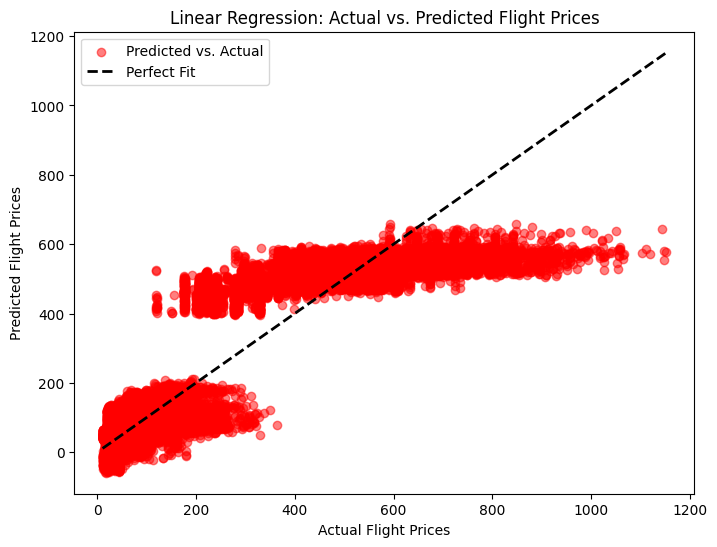

In [ ]:
# Scatterplot- actual vs. predicted prices
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_LR, color='r', alpha=0.5, label='Predicted vs. Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2, label='Perfect Fit')
plt.xlabel('Actual Flight Prices')
plt.ylabel('Predicted Flight Prices')
plt.title('Linear Regression: Actual vs. Predicted Flight Prices')
plt.legend()
plt.show()

# **Random Forest**

In [ ]:
#Encode price variable
from scipy.stats import norm
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
n_bins = 2
df = pd.DataFrame(data=norm.rvs(loc=500, scale=50, size=100),
                  columns=['price'])
y = label_encoder.fit_transform(pd.cut(flight_encode['price'], n_bins, retbins=True)[0])

Random Forest Regression:
MAE: 32.052325809004785
MSE: 2874.8437042521455
RMSE: 53.61756898864537
R-squared: 0.9441416199692922


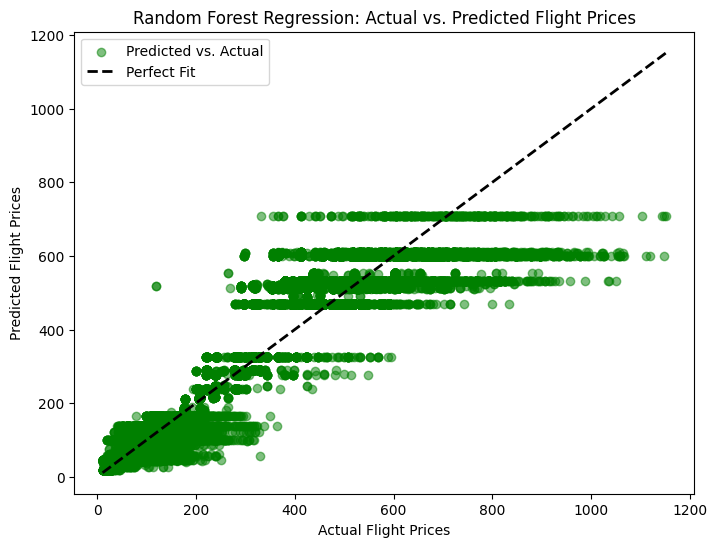

In [ ]:
#Random Forest
rf_model  = RandomForestRegressor(max_depth=5, random_state=0)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
r2_RF = r2_score(y_test, y_pred_rf)

# Evaluate the model on the test set
print("Random Forest Regression:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_rf)}")
print(f"MSE: {mean_squared_error(y_test, y_pred_rf)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf))}")
print(f"R-squared: {r2_score(y_test, y_pred_rf)}")

# Scatterplot - actual vs. predicted prices
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, color='g', alpha=0.5, label='Predicted vs. Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2, label='Perfect Fit')
plt.xlabel('Actual Flight Prices')
plt.ylabel('Predicted Flight Prices')
plt.title('Random Forest Regression: Actual vs. Predicted Flight Prices')
plt.legend()
plt.show()

The average absolute error for this model is around 32 dollars. There is a high MSE of ~2874 dollars. However, the RMSE is on the lower side at 53 dollars, which shows a lower prediction error for this model. The r-squared variable shows that around 94% of the variance in flight price is explained by our random forest model.

# **Boosted Tree**

In [ ]:
#Boosted Trees
from sklearn.ensemble import GradientBoostingRegressor

# Train the boosted tree model
BT = GradientBoostingRegressor()
BT.fit(X_train_scaled, y_train)
y_pred_BT = BT.predict(X_test_scaled)
r2_BT = r2_score(y_test, y_pred_BT)

Boosted Tree Regression:
MAE: 29.46458534756503
MSE: 2438.9531498511724
RMSE: 49.385758573207845
R-squared: 0.9526109987405669


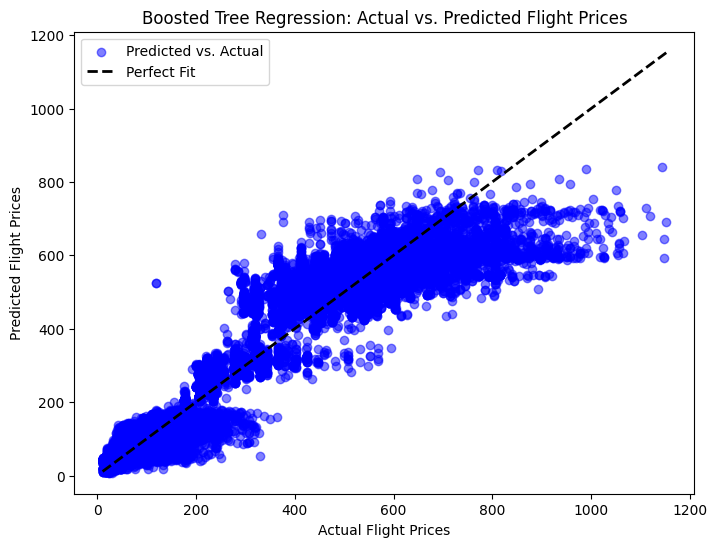

In [ ]:
# Evaluation of Boosted Tree
print("Boosted Tree Regression:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_BT)}")
print(f"MSE: {mean_squared_error(y_test, y_pred_BT)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_BT))}")
print(f"R-squared: {r2_score(y_test, y_pred_BT)}")

# Scatterplot - actual vs. predicted prices
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_BT, color='b', alpha=0.5, label='Predicted vs. Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2, label='Perfect Fit')
plt.xlabel('Actual Flight Prices')
plt.ylabel('Predicted Flight Prices')
plt.title('Boosted Tree Regression: Actual vs. Predicted Flight Prices')
plt.legend()
plt.show()

The MAE value is around 29 dollars while the RMSE is only 49 dollars. This boosted tree regression model has good performance, with low error based on MAE and RMSE. Additionally, the r-squared value indicates that 95% of the variance in flight price is explained by the model. The MSE is around 2438, which is consistent with other models developed.

**Note:** Our group did not perform Naive Bayes analysis, as our target variable is continuous.

# Keras Regression

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print('Training dataset shape: ', X_train.shape)
print('Test dataset shape: ', X_test.shape)

Training dataset shape:  (210107, 9)
Test dataset shape:  (90046, 9)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(Dense(19,activation='relu'))
model.add(Dense(19,activation='relu'))
model.add(Dense(19,activation='relu'))
model.add(Dense(19,activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

model.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=32,epochs=100)

Epoch 1/100
6566/6566 [==============================] - 21s 3ms/step - loss: 6071.1538 - val_loss: 2997.6340
Epoch 2/100
6566/6566 [==============================] - 19s 3ms/step - loss: 2990.1582 - val_loss: 3031.2180
Epoch 3/100
6566/6566 [==============================] - 17s 3ms/step - loss: 2914.3877 - val_loss: 2851.8047
Epoch 4/100
6566/6566 [==============================] - 17s 3ms/step - loss: 2851.2417 - val_loss: 2812.9673
Epoch 5/100
6566/6566 [==============================] - 18s 3ms/step - loss: 2804.8721 - val_loss: 2735.7197
Epoch 6/100
6566/6566 [==============================] - 18s 3ms/step - loss: 2758.4561 - val_loss: 2725.1724
Epoch 7/100
6566/6566 [==============================] - 18s 3ms/step - loss: 2703.9309 - val_loss: 2702.4958
Epoch 8/100
6566/6566 [==============================] - 17s 3ms/step - loss: 2655.0732 - val_loss: 2597.9280
Epoch 9/100
6566/6566 [==============================] - 17s 3ms/step - loss: 2616.6501 - val_loss: 2582.0295
Epoch 10/1

<Axes: >

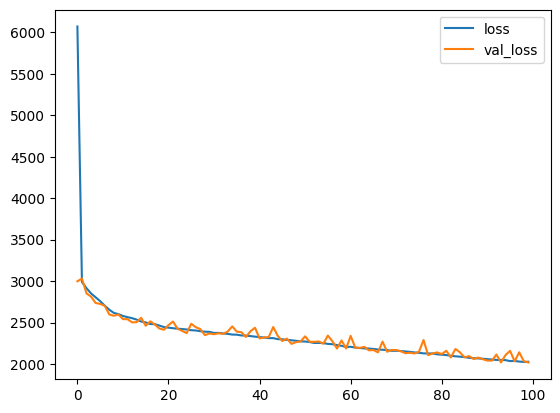

In [ ]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score

y_pred = model.predict(X_test)

print('Mean price: ', flight_encode['price'].mean())
print('Mean price: ', flight_encode['price'].median())

print('MAE: ', mean_absolute_error(y_test,y_pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_test,y_pred)))
print('Variance explained: ',explained_variance_score(y_test,y_pred))

2814/2814 [==============================] - 12s 4ms/step
Mean price:  208.89660523133202
Mean price:  74.25
MAE:  26.126821388351555
RMSE:  44.92965895968655
Variance explained:  0.9610046258261794


<ipython-input-31-08a8fb60d2fb>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Algorithms', y='R2Scores', data=result, palette='Set1')


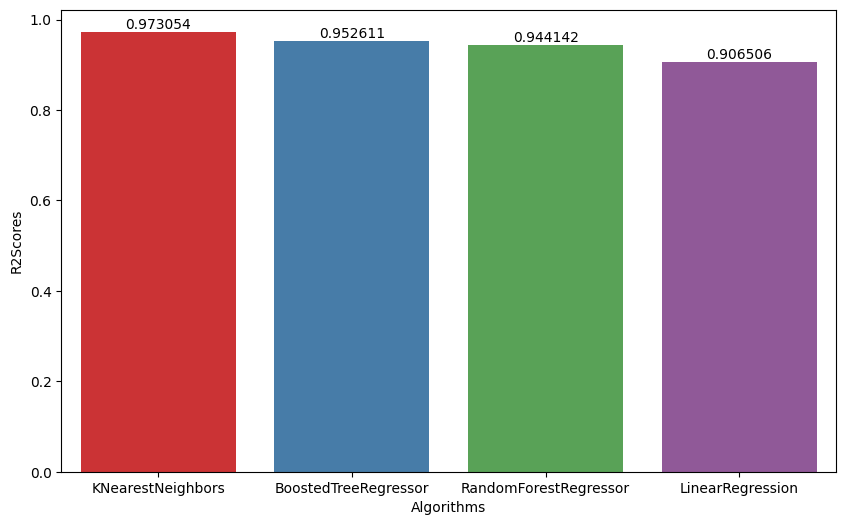

2814/2814 [==============================] - 8s 3ms/step - loss: 2018.6727


TypeError: cannot unpack non-iterable float object

In [ ]:
result = pd.DataFrame({
    'Algorithms' : ['KNearestNeighbors','BoostedTreeRegressor','RandomForestRegressor','LinearRegression',],
    'R2Scores' : [knn_r2, r2_BT, r2_RF, r2_LR]
})
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Algorithms', y='R2Scores', data=result, palette='Set1')
for container in ax.containers:
    ax.bar_label(container)
plt.show()

# Evaluate the model on the test data
test_loss, r2_score = model.evaluate(X_test, y_test.values)
print(f"Test Loss: {test_loss:.4f}")
print(f"R² Score: {r2_score:.4f}")
